Notes:
 * same as 6-2 but with no TOI data in training set

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2'
data_files = '/mnt/tess/astronet/tfrecords-vetting-6-toi-val/*'
tces_file = '/mnt/tess/astronet/tces-vetting-v5-toi-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/1/AstroCNNModelVetting_vrevised_tuned_20211023_235405',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/2/AstroCNNModelVetting_vrevised_tuned_20211024_001859',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/3/AstroCNNModelVetting_vrevised_tuned_20211024_004345',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/4/AstroCNNModelVetting_vrevised_tuned_20211024_010836',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/5/AstroCNNModelVetting_vrevised_tuned_20211024_013348',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/6/AstroCNNModelVetting_vrevised_tuned_20211024_020004',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/7/AstroCNNModelVetting_vrevised_tuned_20211024_022515',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_run_2/8/AstroCNNModelVetting_vrevised_tuned_20211024_025017',
 '/mnt/tess/astronet/checkpoints/vrevised_tuned_6_notoi_

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
354 records
Running model 2
354 records
Running model 3
354 records
Running model 4
354 records
Running model 5
354 records
Running model 6
354 records
Running model 7
354 records
Running model 8
354 records
Running model 9
354 records
Running model 10
354 records


In [3]:
labels = ['disp_p', 'disp_e', 'disp_n']

col_p = labels.index('disp_p')
thresh = 0.1579816417694639

In [15]:
all_preds_table = ensemble_preds[0].copy()
all_preds_table['model'] = 0

for i in range(len(ensemble_preds[1:])):
    tmp = ensemble_preds[i].copy()
    tmp['model'] = i
    all_preds_table = all_preds_table.append(tmp)
    
all_preds_table.to_csv('notoi_ensemble_preds.csv')

In [4]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_p] >= thresh:
            agg_preds[tic_id].append('disp_p')
        else:
            agg_preds[tic_id].append(preds.columns[np.argmax(pred_v)])

In [5]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [6]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [7]:
ppos = (pl['disp_p_p'] > 0)
pos = (pl['disp_p'] > 0)

pneg = (pl['disp_p_p'] == 0)
neg = (pl['disp_p'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.971830985915493
Precision: 0.8117647058823529


In [8]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

29984131
283156726
219208037
121603086


In [9]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

119774374
23826331
24491836
276645751
276936320
278225267
278866211
280095254
30275619
304729846
307153959
344978642
380783252
384068226
384744828
424876542
98350979
142963071
137778682
365494323
388076435
421154783
149854222
326974824
262173985
321828403
24004619
457138169
255994336
1715469662
1715469667
272783172


In [10]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 113428669)

,disp_p,disp_e,disp_n
tic_id,,,
113428669,0.934916,0.049846,0.015237
113428669,0.912334,0.081304,0.006362
113428669,0.648020,0.336243,0.015737
113428669,0.892884,0.090375,0.016741
113428669,0.938803,0.049757,0.011440
113428669,0.878660,0.114032,0.007308
113428669,0.882939,0.100658,0.016403
113428669,0.756971,0.223800,0.019230
113428669,0.929319,0.055864,0.014817


In [11]:
pl[pl.index == 113428669]

,disp_p_p,disp_e_p,disp_n_p,maxcount,disp_p,disp_e,disp_n
tic_id,,,,,,,
113428669,10,0,0,10,1,0,0


### PR curve

In [12]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_ps = np.zeros([len(ensemble_preds), len(tic_index)])
pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
pred_ns = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_p = row[0], row[1][col_p]
        pred_ps[i][tic_index[tic]] = pred_p
        pred_es[i][tic_index[tic]] = row[1][labels.index('disp_e')]
        pred_ns[i][tic_index[tic]] = row[1][labels.index('disp_n')]

lbl_ps = np.zeros([len(tic_index)], dtype=np.bool)
bad_labels = []
for row in tce_labels.iterrows():
    tic, lbl_p = row[0], row[1]['disp_p']
    if tic in tic_index:
        lbl_ps[tic_index[tic]] = (lbl_p > 0)
    else:
        bad_labels.append(tic)

In [13]:
num_cond_pos = float(np.sum(lbl_ps))

def pr_at_th(th):
    pred_pos = np.any(pred_ps >= th, axis=0)
    true_pos = pred_pos & lbl_ps
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9352318302797329, max R: 1.0, max P: 1.0
100% recall at: 74%, threshold: 0.031026408672385597


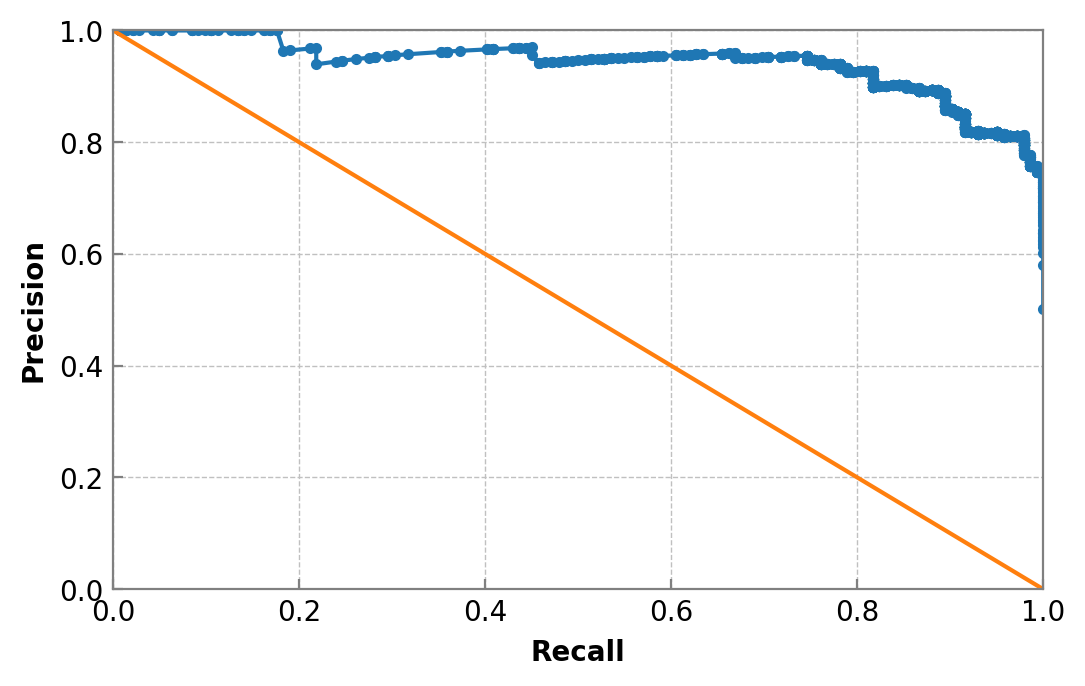

In [14]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_ps)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps, marker='.')
_ = plt.plot([0.0, 1.0], [1.0, 0.0])